# Imports

In [1]:
!pip install optuna
!pip install darts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 26.5 MB/s eta 0:00:00

In [2]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt

import optuna
import torch
from pytorch_lightning.callbacks import EarlyStopping
#from optuna.integration import PyTorchLightningPruningCallback  ## -- causes error --> workaround suggested on  https://github.com/optuna/optuna-examples/issues/166#issuecomment-1403112861
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

from darts import TimeSeries
from darts.models import TransformerModel
from darts.metrics import mae, mape
from darts.utils.likelihood_models import GaussianLikelihood

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Improving Model Performance | Target = Snowfall

## Getting Started | Import basic dataset & preprocess

In [ ]:
# for future reference - get data directly from api?
# fetch_weather_data()

In [4]:
# in the meantime use preprocessed csv (refer to notebook_Anita-Gei_get_preprocessed_data.ipynb for more info)

df = pd.read_csv('/content/historical_data_preprocessed.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns='Unnamed: 0')
df = df.set_index('date')
df.tail(2)

,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,1.403548,-0.129623,-1.404447,...,-0.413650,-0.063053,-0.097270,-0.565147,-0.500000,0.866025,0.0,1.0,0.0,1.0
2024-01-01 23:00:00,0.0,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,1.403548,-0.280686,-1.495166,...,-0.427446,-0.142219,-0.044957,-0.565147,-0.258819,0.965926,0.0,1.0,0.0,1.0


In [5]:
print(df.shape)

(131496, 28)


## Feature Engineering

In [6]:
# Create lag features for snowfall and precipitation
lags = [1, 3, 6, 12]
for lag in lags:
    df[f'snowfall_lag_{lag}'] = df['snowfall'].shift(lag)
    df[f'precipitation_lag_{lag}'] = df['precipitation'].shift(lag)

df.tail(2)

,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,month_sin,month_cos,snowfall_lag_1,precipitation_lag_1,snowfall_lag_3,precipitation_lag_3,snowfall_lag_6,precipitation_lag_6,snowfall_lag_12,precipitation_lag_12
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,1.403548,-0.129623,-1.404447,...,0.0,1.0,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763
2024-01-01 23:00:00,0.0,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,1.403548,-0.280686,-1.495166,...,0.0,1.0,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763


In [7]:
# Add rolling statistics
df['cloud_cover_rolling_mean_3h'] = df['cloud_cover'].rolling(window=3).mean()
df['precipitation_rolling_std_6h'] = df['precipitation'].rolling(window=6).std()
df.tail(2)

,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,snowfall_lag_1,precipitation_lag_1,snowfall_lag_3,precipitation_lag_3,snowfall_lag_6,precipitation_lag_6,snowfall_lag_12,precipitation_lag_12,cloud_cover_rolling_mean_3h,precipitation_rolling_std_6h
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,1.403548,-0.129623,-1.404447,...,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.182911,0.0
2024-01-01 23:00:00,0.0,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,1.403548,-0.280686,-1.495166,...,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.309300,0.0


In [8]:
# Drop rows with NaN values (introduced by lags and rolling)
df = df.dropna()
print(df.shape)

(131484, 38)


## Use Subset of Data while finding the "best" Model!

In [9]:
train_df = df[-30000:]
print(train_df.shape)
train_df.tail(2)

(30000, 38)


,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,snowfall_lag_1,precipitation_lag_1,snowfall_lag_3,precipitation_lag_3,snowfall_lag_6,precipitation_lag_6,snowfall_lag_12,precipitation_lag_12,cloud_cover_rolling_mean_3h,precipitation_rolling_std_6h
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,1.403548,-0.129623,-1.404447,...,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.182911,0.0
2024-01-01 23:00:00,0.0,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,1.403548,-0.280686,-1.495166,...,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.309300,0.0


## Create Time Series

In [10]:
feature_columns = df.drop(columns=['snowfall']).columns.tolist()

snowfall_series = TimeSeries.from_dataframe(df, value_cols='snowfall')
feature_series = TimeSeries.from_dataframe(df, value_cols=feature_columns)

## Split into Train, Validation and Test Sets

In [11]:
y_train_val, y_test = snowfall_series.split_before(0.8)
y_train, y_val = y_train_val.split_before(0.8)

X_train_val, X_test = feature_series.split_before(0.8)
X_train, X_val = X_train_val.split_before(0.8)

## Optimize Hyperparamters with Optuna

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
# Workaround to get PyTorchLightningPruningCallback working

class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

In [ ]:
def objective(trial):
    d_model = trial.suggest_categorical("d_model", [128, 256, 512])
    nhead = trial.suggest_categorical("nhead", [4, 8])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_encoder_layers = trial.suggest_categorical("num_encoder_layers", [2, 3, 6])
    num_decoder_layers = trial.suggest_categorical("num_decoder_layers", [2, 3, 6])
    dim_feedforward = trial.suggest_categorical("dim_feedforward", [256, 512, 1024])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "gelu", "ReLU"])

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [pruner, early_stopper]

    # detect if a GPU is available
    if torch.cuda.is_available():
        num_workers = 4
    else:
        num_workers = 0

    pl_trainer_kwargs = {
        "accelerator": "gpu", #only on Colab!
        "devices": -1,
        "callbacks": callbacks,
    }

    # reproducibility
    torch.manual_seed(42)

    # build the Transformer model
    model = TransformerModel(
        input_chunk_length=48,
        output_chunk_length=48,
        batch_size=batch_size,
        n_epochs=100,
        nr_epochs_val_period=1,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        d_model=d_model,
        nhead=nhead,
        activation=activation,
        dim_feedforward=dim_feedforward,
        pl_trainer_kwargs=pl_trainer_kwargs,
        likelihood=GaussianLikelihood(),
        model_name="trf_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # train the model
    model.fit(
        series=y_train,
        past_covariates=X_train,
        val_series=y_val,
        val_past_covariates=X_val,
    )

    # reload best model over course of training
    model = TransformerModel.load_from_checkpoint("trf_model")

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=y_train, n=48)
    maes = mae(y_val[:48], preds, n_jobs=-1, verbose=True)
    mae_val = np.mean(maes)

    return mae_val if mae_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the maes on the validation set
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10, callbacks=[print_callback])

[I 2024-12-17 13:07:29,380] A new study created in memory with name: no-name-583b668a-708d-4d28-85a9-8058b1960d34
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Print best parameters
print(study.best_value)
print(f"Best trial: {study.best_trial.params}")

0.046599105752250625
Best trial: {'d_model': 128, 'nhead': 8, 'dropout': 0.2, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dim_feedforward': 1024, 'lr': 0.0008735198968515869}


## Initialize Model with optimized Parameters

In [27]:
#fill after completing optuna study!
early_stopper = EarlyStopping("train_loss", min_delta=0.01, patience=12, verbose=True)
callbacks = [early_stopper]

pl_trainer_kwargs ={
        "accelerator": "gpu", #only on Colab!
        "devices": -1,
        "callbacks": callbacks,
    }

model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=48,
    batch_size=64,
    n_epochs=100,
    nr_epochs_val_period=1,
    dropout=0.2,
    optimizer_kwargs={"lr": 0.0008735198968515869},
    num_encoder_layers=3,
    num_decoder_layers=2,
    d_model=128,
    nhead=8,
    dim_feedforward=1024,
    pl_trainer_kwargs=pl_trainer_kwargs,
    likelihood=GaussianLikelihood(),
    model_name="snowfall_model",
    force_reset=True,
    random_state=42
    )

## Fit Model - on whole dataset!

In [28]:
model.fit(
    series=y_train,
    past_covariates=X_train,
    val_series=y_val,
    val_past_covariates=X_val,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: -0.551


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.115 >= min_delta = 0.01. New best score: -0.666


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.125 >= min_delta = 0.01. New best score: -0.791


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.509 >= min_delta = 0.01. New best score: -1.301


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.197 >= min_delta = 0.01. New best score: -1.497


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.339 >= min_delta = 0.01. New best score: -1.836


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# Save Model

In [21]:
model.save("snowfall_model.pt")

# Load Model

In [3]:
model = TransformerModel.load('/content/snowfall_model.pt')

/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1747: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

## Make Predictions

In [22]:
forecast = model.predict(n=48, past_covariates=X_train_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
forecast.values()

array([[ 0.00092437],
       [ 0.00306524],
       [ 0.00279646],
       [ 0.01138818],
       [-0.00163265],
       [ 0.00022768],
       [ 0.00644049],
       [-0.00902033],
       [-0.00243342],
       [ 0.00646677],
       [-0.00051883],
       [ 0.00571414],
       [-0.00937687],
       [-0.02363159],
       [-0.00494541],
       [-0.00492655],
       [ 0.01103044],
       [-0.00753708],
       [-0.00627877],
       [-0.00915157],
       [-0.01615676],
       [-0.01317284],
       [-0.01903343],
       [-0.01803619],
       [-0.01609229],
       [-0.02756217],
       [ 0.00056928],
       [-0.00790547],
       [-0.05528326],
       [-0.01359215],
       [ 0.00568029],
       [ 0.05531809],
       [ 0.03708737],
       [-0.00069423],
       [-0.0616625 ],
       [ 0.02937697],
       [ 0.01110741],
       [-0.03200885],
       [-0.03919182],
       [-0.03200909],
       [-0.01654662],
       [-0.02100664],
       [ 0.03363776],
       [ 0.0654009 ],
       [-0.099232  ],
       [-0

## Backtesting and Historical Forecasting

In [24]:
historical_forecast = model.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=6,
    retrain=True,
    overlap_end=True,
    verbose=True
)

error_mae = mae(snowfall_series.slice_intersect(historical_forecast), historical_forecast)


  0%|          | 0/5260 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss            

Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/5260 [00:27<?, ?it/s]


RuntimeError: Early stopping conditioned on metric `val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`

In [ ]:
error_mae

0.19774705079184304

# Plot historical forecast vs actuals

NameError: name 'plt' is not defined

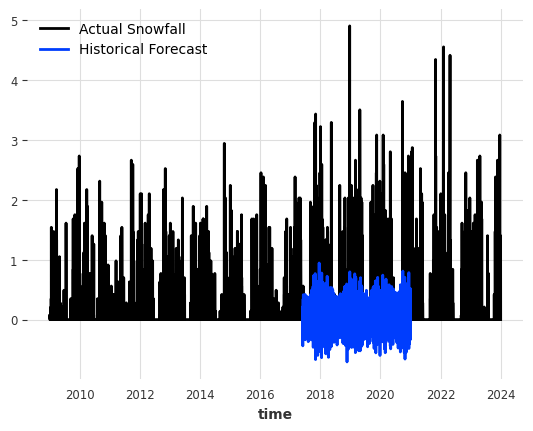

In [ ]:
snowfall_series.plot(label="Actual Snowfall")
historical_forecast.plot(label="Historical Forecast")
plt.legend()
plt.show();

## Backtest Snowfall Model

In [ ]:
backtest_mae = model.backtest(
    series=y_test,
    past_covariates=X_test,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=True,
    metric=mae,
    verbose=True
)

print(f"Backtest MAE: {backtest_mae}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest MAE: 0.16154238046205646
